In [1]:
import numpy as np
from scipy.sparse import csr_matrix
from scipy.integrate import ode
import itertools
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 12})
import warnings
warnings.filterwarnings("ignore")

def generate_single_particle_basis(N):
    """Generate basis states for a single particle in N sites."""
    basis = [(1 << i) for i in range(N)]
    return np.array(basis, dtype=np.uint64), N

def construct_hamiltonian(N, basis, basis_size, t=1.0):
    """Construct free fermion Hamiltonian with hopping term t."""
    row = []
    col = []
    data = []
    
    for i in range(basis_size):
        state = basis[i]
        for j in range(N - 1):  # Loop over sites for hopping
            if (state >> j) & 1 and not (state >> (j + 1)) & 1:
                new_state = state ^ (1 << j) ^ (1 << (j + 1))
                phase = 1
                for k in range(j + 1, j + 2):
                    if (state >> k) & 1:
                        phase *= -1
                idx = np.where(basis == new_state)[0]
                if len(idx) > 0:
                    row.append(i)
                    col.append(idx[0])
                    data.append(-t * phase)
            if not (state >> j) & 1 and (state >> (j + 1)) & 1:
                new_state = state ^ (1 << j) ^ (1 << (j + 1))
                phase = 1
                for k in range(j, j + 1):
                    if (state >> k) & 1:
                        phase *= -1
                idx = np.where(basis == new_state)[0]
                if len(idx) > 0:
                    row.append(i)
                    col.append(idx[0])
                    data.append(-t * phase)
    
    return csr_matrix((data, (row, col)), shape=(basis_size, basis_size))

def time_evolution(psi0, H, t_span, dt):
    """Solve time-dependent Schrödinger equation."""
    def schrodinger(t, psi):
        return -1j * H.dot(psi)
    
    solver = ode(schrodinger).set_integrator('zvode', method='bdf')
    solver.set_initial_value(psi0, t_span[0])
    
    times = np.arange(t_span[0], t_span[1], dt)
    psi_t = [psi0.copy()]
    
    for t in times[1:]:
        solver.integrate(t)
        psi_t.append(solver.y.copy())
    
    return times, np.array(psi_t)

def compute_density(N, basis, psi_t):
    """Compute particle density for each site over time."""
    density = np.zeros((len(psi_t), N))
    for t_idx, psi in enumerate(psi_t):
        for i, state in enumerate(basis):
            for site in range(N):
                if (state >> site) & 1:
                    density[t_idx, site] += np.abs(psi[i])**2
    return density

def plot_densities(times, n_up, n_down, N):
    """Plot spin-down (left, blue), spin-up (middle, red), and total density (right, binary) as colormaps."""
    total_density = n_up + n_down
    fig, axes = plt.subplots(1, 3, figsize=(18, 5), sharey=True)
    extent = [1, N, times[0], times[-1]]
    
    # Plot spin-down density (left, blue)
    im1 = axes[0].imshow(n_down, aspect='auto', origin='lower', extent=extent, cmap='Blues', interpolation='none')
    axes[0].set_title(r'Spin-down fermion density $\langle n_{\downarrow,i}(t) \rangle$')
    axes[0].set_xlabel('Site index $i$')
    axes[0].set_ylabel('Time $t$ $[\hbar/|t|]$')
    
    # Plot spin-up density (middle, red)
    im2 = axes[1].imshow(n_up, aspect='auto', origin='lower', extent=extent, cmap='Reds', interpolation='none')
    axes[1].set_title(r'Spin-up fermion density $\langle n_{\uparrow,i}(t) \rangle$')
    axes[1].set_xlabel('Site index $i$')
    
    # Plot total density (right, binary)
    im3 = axes[2].imshow(total_density, aspect='auto', origin='lower', extent=extent, cmap='binary', interpolation='none')
    axes[2].set_title(r'Total fermion density $\langle n_{\uparrow,i}(t) + n_{\downarrow,i}(t) \rangle$')
    axes[2].set_xlabel('Site index $i$')
    
    # Add colorbars
    cbar1 = fig.colorbar(im1, ax=axes[0], fraction=0.046, pad=0.04)
    cbar2 = fig.colorbar(im2, ax=axes[1], fraction=0.046, pad=0.04)
    cbar3 = fig.colorbar(im3, ax=axes[2], fraction=0.046, pad=0.04)
    
    # Set x-ticks and limits
    xticks = list(range(0, N + 1, 5))
    for ax in axes:
        ax.set_xticks(xticks)
        ax.set_xlim(1, N)
    
    plt.tight_layout()
    plt.show()

def plot_magnetization(times, n_up, n_down, N):
    """Plot magnetization as a colormap using a diverging color scale."""
    magnetization = n_down - n_up  # +1 for spin-up, -1 for spin-down
    fig, ax = plt.subplots(figsize=(7, 5))
    extent = [1, N, times[0], times[-1]]

    # Plot magnetization
    im = ax.imshow(magnetization, aspect='auto', origin='lower', extent=extent,
                   cmap='RdBu', interpolation='none', vmin=-1, vmax=1)

    ax.set_title(r'Fermion magnetization $\langle n_{\downarrow,i}(t) - n_{\uparrow,i}(t) \rangle$')
    ax.set_xlabel('Site index $i$')
    ax.set_ylabel('Time $t$ $[\hbar/|t|]$')

    # Colorbar
    cbar = fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
    #cbar.set_label("Magnetization")

    # Set x-ticks and limits
    xticks = list(range(0, N + 1, 5))
    ax.set_xticks(xticks)
    ax.set_xlim(1, N)

    plt.tight_layout()
    plt.show()

import matplotlib.animation as animation

def animate_spin_densities(times, n_up, n_down, N, filename="spin_densities.gif", fps=30):
    """
    Animate spin-up and spin-down site occupations over time.

    Parameters
    ----------
    times : array_like
        1D array of time points.
    n_up : array_like
        2D array of spin-up occupations (len(times) x N).
    n_down : array_like
        2D array of spin-down occupations (len(times) x N).
    N : int
        Number of sites.
    filename : str
        Output GIF filename.
    fps : int
        Frames per second for the animation.
    """
    fig, ax = plt.subplots(figsize=(6, 4))
    
    # Create two line objects
    line_up, = ax.plot([], [], lw=2, color="red", label=r"$\langle n_\uparrow \rangle$")
    line_down, = ax.plot([], [], lw=2, color="blue", label=r"$\langle n_\downarrow \rangle$")
    
    ax.set_xlim(1, N)
    ax.set_ylim(0, 1)
    ax.set_xlabel("Site index")
    ax.set_ylabel(r"Occupation $\langle n_\alpha \rangle$")
    ax.legend(loc="upper right")
    ax.set_title("Spin dynamics for free fermions")
    fig.tight_layout()
    
    # Time text box at top center
    time_text = ax.text(
        0.5, 0.9, "", transform=ax.transAxes,
        ha="center", va="bottom",
        fontsize=11, bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="gray", lw=1)
    )
    
    def init():
        line_up.set_data([], [])
        line_down.set_data([], [])
        time_text.set_text("")
        return line_up, line_down, time_text
    
    def update(frame):
        t = times[frame]
        xdata = range(1, N + 1)
        line_up.set_data(xdata, n_up[frame])
        line_down.set_data(xdata, n_down[frame])
        time_text.set_text(f"t = {t:.2f}")
        return line_up, line_down, time_text
    
    ani = animation.FuncAnimation(
        fig, update, frames=len(times), init_func=init, blit=True
    )
    
    ani.save(filename, writer="pillow", fps=fps)
    plt.close(fig)

def main():
    # Parameters
    N = 50  # Number of sites
    t_hopping = 1.0  # Hopping strength
    t_span = (0, 40)  # Time span for evolution
    dt = 0.16  # Time step
    
    # Generate basis for single particle (one for each spin)
    basis, basis_size = generate_single_particle_basis(N)
    print(f"Basis size per spin: {basis_size}")
    
    # Construct Hamiltonians for spin-up and spin-down
    H = construct_hamiltonian(N, basis, basis_size, t_hopping)
    
    # Initial state: Spin-up at site N-1, spin-down at site 0
    psi0_up = np.zeros(basis_size, dtype=complex)
    psi0_up[N - 1] = 1.0  # Spin-up at site N-1
    psi0_down = np.zeros(basis_size, dtype=complex)
    psi0_down[0] = 1.0  # Spin-down at site 0
    
    # Time evolution for each spin
    times, psi_t_up = time_evolution(psi0_up, H, t_span, dt)
    times, psi_t_down = time_evolution(psi0_down, H, t_span, dt)
    
    # Compute density for each spin
    n_up = compute_density(N, basis, psi_t_up)
    n_down = compute_density(N, basis, psi_t_down)
    
    # Plot densities
    plot_densities(times, n_up, n_down, N)
    plot_magnetization(times, n_up, n_down, N)
    
    animate_spin_densities(times, n_up, n_down, N, filename="fermion_dynamics.gif", fps=30)


<>:86: SyntaxWarning: invalid escape sequence '\h'
<>:124: SyntaxWarning: invalid escape sequence '\h'
<>:86: SyntaxWarning: invalid escape sequence '\h'
<>:124: SyntaxWarning: invalid escape sequence '\h'
C:\Users\Joe\AppData\Local\Temp\ipykernel_28180\3254611607.py:86: SyntaxWarning: invalid escape sequence '\h'
  axes[0].set_ylabel('Time $t$ $[\hbar/|t|]$')
C:\Users\Joe\AppData\Local\Temp\ipykernel_28180\3254611607.py:124: SyntaxWarning: invalid escape sequence '\h'
  ax.set_ylabel('Time $t$ $[\hbar/|t|]$')


Basis size per spin: 50


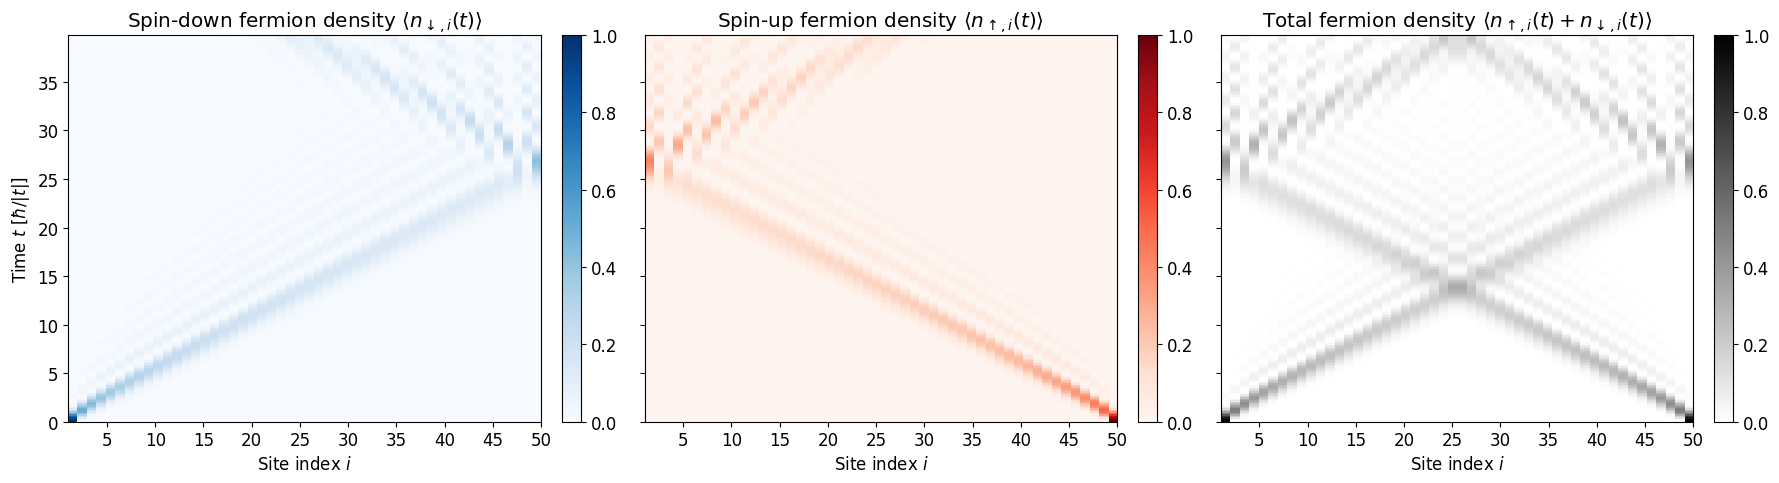

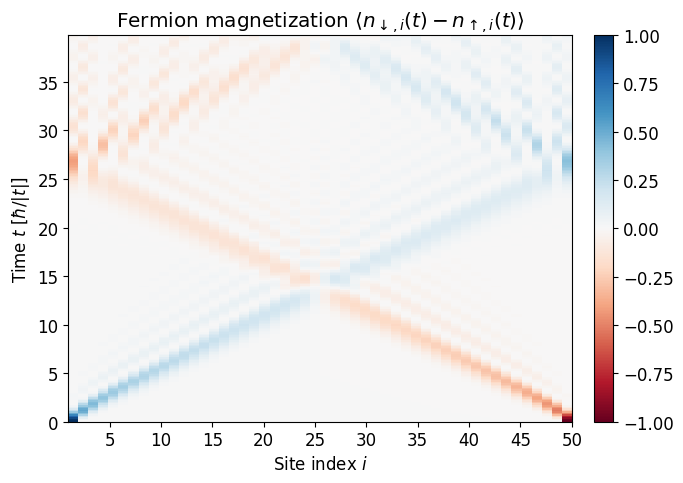

In [2]:
main()